# DSCI 571: Supervised Machine Learning I 

## Lecture 7: Naive Bayes

UBC Master of Data Science program, 2020-21

Instructor: Varada Kolhatkar


In [1]:
# And import the libraries
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML

%pylab inline
# pip install git+git://github.com/mgelbart/plot-classifier.git
from plot_classifier import plot_classifier
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
    TfidfVectorizer,
)

# train test split and cross validation
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)

from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB

pd.set_option("display.max_colwidth", 200)

Populating the interactive namespace from numpy and matplotlib


## Lecture learning objectives

From this lecture, you will be able to 

- Explain the naive assumption of naive Bayes. 
- Predict targets by hand on toy examples using naive Bayes.
- Use `scikit-learn`'s `MultiNomialNB`, `BernoulliNB`, and `GaussianNB`. 
- Use `predict_proba` for different classifiers and explain its usefulness. 
- Explain the need of smoothing in naive Bayes.
- Explain how `alpha` controls the fundamental tradeoff. 
- Use naive Bayes for multi-class classification. 
- Name advantages and disadvantages of naive Bayes. 

## 1. Motivating example


### Example: spam/non spam
Last week in your lab you worked on spam classification using `SVC` classifier. 

$X = \begin{bmatrix}\text{"URGENT!! You have been selected to receive a £900 prize reward!",}\\ \text{"Lol your always so convincing."}\\ \text{"Congrats! 1 year special cinema pass for 2 is yours. call 09061209465 now!"}\\ \end{bmatrix}$ and $y = \begin{bmatrix}\text{spam} \\ \text{non spam} \\ \text{spam} \end{bmatrix}$


ML algorithms we have seen so far prefer fixed length numeric input that looks like this: 

$X = \begin{bmatrix}1.0 & 4.0 & \ldots & & 3.0\\ 0.0 & 2.0 & \ldots & & 6.0\\ 1.0 & 0.0 & \ldots & & 0.0\\ \end{bmatrix}$ and $y = \begin{bmatrix}\text{spam} \\ \text{non spam} \\ \text{spam} \end{bmatrix}$


#### `CountVectorizer` to get bag-of-words (BOW) representation

- So we used `CountVectorizer` to convert text data into feature vectors where
    - each feature is a unique word in the text  
    - each feature value represents the frequency or presence/absence of the word in the given message         
    
<img src='./images/bag-of-words.png' width="800">

[Source](https://web.stanford.edu/~jurafsky/slp3/4.pdf)       

### Naive Bayes

- For years, best spam filtering methods used naive Bayes.
- Our first probabilistic classifier where we think of learning as a problem of statistical inference.

## 2. Naive Bayes classifier


Before understanding the theory, let's try `scikit-learn`'s implementation of Naive Bayes on Kaggle's [SMS Spam Collection Dataset](https://www.kaggle.com/uciml/sms-spam-collection-dataset).

In [2]:
sms_df = pd.read_csv("data/spam.csv", encoding="latin-1")
sms_df = sms_df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
sms_df = sms_df.rename(columns={"v1": "target", "v2": "sms"})

In [3]:
train_df, test_df = train_test_split(sms_df, test_size=0.2, random_state=123)
X_train, y_train = train_df["sms"], train_df["target"]
X_test, y_test = test_df["sms"], test_df["target"]
train_df.head()

,target,sms
385,ham,It took Mr owl 3 licks
4003,ham,Well there's a pattern emerging of my friends telling me to drive up and come smoke with them and then telling me that I'm a weed fiend/make them smoke too much/impede their doing other things so ...
1283,ham,Yes i thought so. Thanks.
2327,spam,"URGENT! Your mobile number *************** WON a å£2000 Bonus Caller prize on 10/06/03! This is the 2nd attempt to reach you! Call 09066368753 ASAP! Box 97N7QP, 150ppm"
1103,ham,Aiyah sorry lor... I watch tv watch until i forgot 2 check my phone.


In [4]:
def store_cross_val_results(model_name, scores, results_dict):
    """
    Stores mean scores from cross_validate in results_dict for
    the given model model_name.

    Parameters
    ----------
    model_name :
        scikit-learn classification model
    scores : dict
        object return by `cross_validate`
    results_dict: dict
        dictionary to store results

    Returns
    ----------
        None

    """
    results_dict[model_name] = {
        "mean_train_accuracy": "{:0.4f}".format(np.mean(scores["train_score"])),
        "mean_valid_accuracy": "{:0.4f}".format(np.mean(scores["test_score"])),
        "mean_fit_time (s)": "{:0.4f}".format(np.mean(scores["fit_time"])),
        "mean_score_time (s)": "{:0.4f}".format(np.mean(scores["score_time"])),
        "std_train_score": "{:0.4f}".format(scores["train_score"].std()),
        "std_valid_score": "{:0.4f}".format(scores["test_score"].std()),
    }

### SVC classifier for spam detection 

- Let's try SVC classifier on our dataset. (This is what you did in the lab last week.)

In [5]:
results_dict = {}
pipe_svc= make_pipeline(CountVectorizer(), SVC())
scores = cross_validate(pipe_svc, X_train, y_train, return_train_score=True)
store_cross_val_results('SVC', scores, results_dict)

In [6]:
pd.DataFrame(results_dict).T

,mean_fit_time (s),mean_score_time (s),mean_train_accuracy,mean_valid_accuracy,std_train_score,std_valid_score
SVC,0.5260,0.1126,0.9950,0.9785,0.0005,0.0048


### `sklearn` naive Bayes classifier 

- Let's try Naive Bayes on this problem. 

In [7]:
from sklearn.naive_bayes import MultinomialNB

pipe_nb = make_pipeline(CountVectorizer(), MultinomialNB())
scores = cross_validate(pipe_nb, X_train, y_train, return_train_score=True)
store_cross_val_results('Naive Bayes', scores, results_dict)

In [8]:
pd.DataFrame(results_dict).T

,mean_train_accuracy,mean_valid_accuracy,mean_fit_time (s),mean_score_time (s),std_train_score,std_valid_score
SVC,0.9950,0.9785,0.5260,0.1126,0.0005,0.0048
Naive Bayes,0.9935,0.9859,0.0422,0.0089,0.0007,0.0026


- The validation scores are a bit better on this particular dataset.
- Way more faster than SVC classifier!! 

### Naive Bayes `predict`

- Given a new message, we want to predict whether it's spam or non spam (ham).
- Example: Predict whether the following message is spam or non spam (ham). 
> "URGENT! Free!!"

In [9]:
pipe_nb = make_pipeline(CountVectorizer(), MultinomialNB())
pipe_nb.fit(X_train, y_train)
deploy_test = ["URGENT! Free!!", "Let's enjoy the last week of block 2!"]
pipe_nb.predict(deploy_test)

array(['spam', 'ham'], dtype='<U4')

### Probabilistic classifiers: `predict` by hand 

- What's it's doing under the hood? 
- Let's look at an example with a toy dataset. 

In [10]:
X = [
    "URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!",
    "Lol you are always so convincing.",
    "Block 2 has interesting courses.",
    "URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!",
    "Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free!",
    "Block 2 has been interesting so far.",
]
y = ["spam", "non spam", "non spam", "spam", "spam", "non spam"]

In [11]:
pipe_nb_toy = make_pipeline(CountVectorizer(max_features = 4, stop_words='english'), MultinomialNB())
pipe_nb_toy.fit(X, y);

In [13]:
data = pipe_nb_toy['countvectorizer'].transform(X)
train_bow_df = pd.DataFrame(data.toarray(), columns=pipe_nb_toy['countvectorizer'].get_feature_names(), index=X)
train_bow_df['target'] = y
train_bow_df

,block,free,prize,urgent,target
URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!,0,0,1,1,spam
Lol you are always so convincing.,0,0,0,0,non spam
Block 2 has interesting courses.,1,0,0,0,non spam
URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!,0,1,1,1,spam
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free!,0,1,0,0,spam
Block 2 has been interesting so far.,1,0,0,0,non spam


Suppose we are given text messages in `deploy_test` and we want to find the targets for these examples, how do we do it using naive Bayes?

First, let's get numeric representation of our text messages. 

In [14]:
deploy_test = ["URGENT! Free!!", "I like block 2."]
data = pipe_nb_toy['countvectorizer'].transform(deploy_test).toarray()
bow_df = pd.DataFrame(data, columns=pipe_nb_toy['countvectorizer'].get_feature_names(), index=deploy_test)
bow_df

,block,free,prize,urgent
URGENT! Free!!,0,1,0,1
I like block 2.,1,0,0,0


### Naive Bayes prediction idea

Suppose we want to predict whether the following message is "spam" or "non spam".
> "URGENT! Free!!"

Representation of the message: `[0, 1, 0, 1]`

To predict the correct class, naive Bayes calculates the following probability scores. 

- $P(\text{spam} \mid \text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent=1})$ 
- $P(\text{non spam} \mid  \text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent=1})$
- Picks the label with higher probability scores. 

### Applying Bayes' theorem 

Uses Bayes' theorem to calculate probabilities:

$$P(A \mid B) = \frac{P(B \mid A) \times P(A)}{P(B)}$$

$$P(\text{spam} \mid \text{message})= \frac{P(\text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent} = 1 \mid \text{spam}) \times P(\text{spam})}{P(\text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent=1})}$$

$$P(\text{non spam} \mid \text{message}) = \frac{P(\text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent} = 1 \mid \text{non spam}) \times P( \text{non spam})}{P(\text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent=1})}$$

- $P(\text{message})$: marginal probability that a message has the given set of words 
    - Hard to calculate but can be ignored in our scenario as it occurs in the denominator for both $P(\text{spam} \mid \text{message})$ and $P(\text{non spam} \mid \text{message})$.
    - So we ignore the denominator in both cases. 


### Let's focus on $P(\text{spam} \mid \text{message})$

- After ignoring the denominator: 
$$P(\text{spam} \mid \text{message}) \propto P(\text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent} = 1 \mid \text{spam}) \times P(\text{spam})$$

- To calculate $P(\text{spam} \mid \text{message})$, we need:  
    - $P(\text{spam})$: marginal probability that a message is spam
    - $P(\text{message}\mid\text{spam})$: conditional probability that message has words $w_1, w_2, \dots, w_d$, given that it is spam.
        - Hard to calculate because it would require huge numbers of parameters and impossibly large training sets. But we need it. 
        - with $d$ binary features, how many possible "text messages" are there?
        - we cannot possibly have access to all the data

### Naive Bayes' approximation to calculate $P(\text{message}|\text{spam})$

- A common assmption is **naive Bayes** assumption, which states that **features are independent, conditioned on the target**. 
    - Example: In our spam classification example, **once you know that a message is spam**, the probability that the word "urgent" appears is independent of whether "free" also appeared. 
    
- We can write this mathematically as 

$$\begin{equation}
\begin{split}
& P(\text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent} = 1 \mid \text{spam}) \\
&\approx P(\text{block} = 0 \mid \text{spam}) \times P(\text{free} = 1 \mid \text{spam}) \times P(\text{prize} = 0 \mid \text{spam}) \times P(\text{urgent} = 1 \mid \text{spam})
\end{split}
\end{equation}$$


### Naive Bayes' approximation

- In general, 
$$P(\text{message} \mid \text{spam}) = P(w_1, w_2, . . . , w_d \mid \text{spam}) \approx \prod_{i=1}^{d}P(w_i \mid \text{spam})$$

$$P(\text{message} \mid \text{non spam}) = P(w_1, w_2, . . . , w_d \mid \text{non spam}) \approx \prod_{i=1}^{d}P(w_i \mid \text{non spam})$$


### Going back to estimating $P(\text{spam} \mid \text{message})$

With naive Bayes' assumption, to calculate $P(\text{spam} \mid \text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent} = 1)$, we need the following:  
1. Prior probability: $P(\text{spam})$ 
2. Conditional probabilities: 
    1. $P(\text{block} = 0 \mid \text{spam})$
    2. $P(\text{free} = 1 \mid \text{spam})$
    3. $P(\text{prize} = 0 \mid \text{spam})$
    4. $P(\text{urgent} = 1 \mid \text{spam})$

We use our training data to calculate these probabilities. 

In [15]:
train_bow_df

,block,free,prize,urgent,target
URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!,0,0,1,1,spam
Lol you are always so convincing.,0,0,0,0,non spam
Block 2 has interesting courses.,1,0,0,0,non spam
URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!,0,1,1,1,spam
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free!,0,1,0,0,spam
Block 2 has been interesting so far.,1,0,0,0,non spam


- Prior probability
    - $P(\text{spam}) = 3/6$
    
- Conditional probabilities
    - What is $P(\text{block} = 0 \mid \text{spam})$? 
        - Given target is spam, how often "block" = 0? $3/3$
    - $P(\text{free} = 1 \mid \text{spam}) = 2/3$ 
    - $P(\text{prize} = 0 \mid \text{spam}) = 1/3$
    - $P(\text{urgent} = 1 \mid \text{spam}) = 2/3$

### Estimating $P(\text{spam} \mid \text{message})$

$$\begin{equation}
\begin{split}
P(\text{spam} \mid \text{message}) &\propto P(\text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent} = 1 \mid \text{spam}) \times P(\text{spam})\\
&\propto P(\text{block} = 0 \mid \text{spam}) \times P(\text{free} = 1 \mid \text{spam}) \\
& \times P(\text{prize} = 0 \mid \text{spam}) \times P(\text{urgent} = 1 \mid \text{spam}) \times P(\text{spam})\\
&\propto 3/3 \times 2/3 \times 1/3 \times 2/3 \times 3/6\\
\end{split}
\end{equation}$$


In [16]:
spam_prior = 3/6
block0_spam = 3/3
free1_spam = 2/3
prize0_spam = 1/3
urgent1_spam = 2/3
spam_prior * block0_spam * free1_spam * prize0_spam * urgent1_spam

0.07407407407407407

### Let's estimate $P(\text{non spam} \mid \text{message})$

With naive Bayes' assumption, to calculate $P(\text{non spam} \mid \text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent} = 1)$, we need the following:  
1. Prior probability: $P(\text{non spam})$ 
2. Conditional probabilities: 
    1. $P(\text{block} = 0 \mid \text{non spam})$
    2. $P(\text{free} = 1 \mid \text{non spam})$
    3. $P(\text{prize} = 0 \mid \text{non spam})$
    4. $P(\text{urgent} = 1 \mid \text{non spam})$

Again we use the data to calculate these probabilities. 

In [17]:
train_bow_df

,block,free,prize,urgent,target
URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!,0,0,1,1,spam
Lol you are always so convincing.,0,0,0,0,non spam
Block 2 has interesting courses.,1,0,0,0,non spam
URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!,0,1,1,1,spam
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free!,0,1,0,0,spam
Block 2 has been interesting so far.,1,0,0,0,non spam


- Prior probability 
    - $P(\text{non spam}) = 3/6$

- Conditional probabilities 
    - What is $P(\text{block} = 0 \mid \text{non spam})$? 
        - Given target is non spam, how often "block" = 0? $1/3$
    - $P(\text{free} = 1 \mid \text{non spam}) = 0/3$ 
    - $P(\text{prize} = 0 \mid \text{non spam}) = 3/3$
    - $P(\text{urgent} = 1 \mid \text{non spam}) = 0/3$

### Estimating $P(\text{non spam} \mid \text{message})$

$$\begin{equation}
\begin{split}
P(\text{non spam} \mid \text{message}) &\propto P(\text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent} = 1 \mid \text{non spam}) \times P(\text{non spam})\\
&\propto P(\text{block} = 0 \mid \text{non spam}) \times P(\text{free} = 1 \mid \text{non spam}) \\
& \times P(\text{prize} = 0 \mid \text{non spam}) \times P(\text{urgent} = 1 \mid \text{non spam}) \times P(\text{non spam})\\
&\propto 1/3 \times 0 \times 3/3 \times 0 \times 1/3\\
\end{split}
\end{equation}$$


In [18]:
non_spam_prior = 3/6
block0_non_spam = 0/3
free1_non_spam = 1/3
prize0_non_spam = 1/3
urgent1_non_spam = 2/3
non_spam_prior * block0_non_spam * free1_non_spam * prize0_non_spam * urgent1_non_spam

0.0

### Naive Bayes prediction

Since $(\text{spam} \mid \text{message})$ (0.074) is proportional to a larger number compared to $(\text{non spam} \mid \text{message})$ (0), we predict $spam$! 

### Exercise for you

- Predict for the second example in our `deploy_test`: "I like block 2."

### Summary naive Bayes `predict`
- Use Bayes rule to calculate the conditional probability of spam or non spam given the message. 

$$ P(\text{spam} \mid \text{message}) = \frac{P(\text{message} \mid \text{spam}) \times P(\text{spam})}{P(\text{message})} $$

$$ P(\text{non spam} \mid \text{message}) = \frac{P(\text{message} \mid \text{non spam}) \times P(\text{non spam})}{P(\text{message})} $$


- $P(\text{message})$: marginal probability that a message has the given set of words 
    - Hard to calculate but can be ignored in our scenario.


### Summary naive Bayes `predict`
$$ P(\text{spam} \mid \text{message}) \propto P(\text{message} \mid\text{spam}) \times P(\text{spam}) =  P(w_1, w_2, \dots, w_d \mid \text{spam}) \times P(\text{spam})$$

- We need the following terms:  
    - $P(\text{spam})$: marginal probability that a message is spam
    - $P(\text{message}\mid\text{spam})$: conditional probability that message has words $w_1, w_2, \dots, w_d$, given that it is spam.
        - Hard to calculate but we need it. We would require huge numbers of parameters and impossibly large training sets. 
        

### Summary naive Bayes `predict`
$$ P(\text{non spam} \mid \text{message}) \propto P(\text{message} \mid\text{non spam}) \times P(\text{non spam}) =  P(w_1, w_2, \dots, w_d \mid \text{non spam}) \times P(\text{non spam})$$

- We need the following terms:  
    - $P(\text{non spam})$: marginal probability that a message is non spam
    - $P(\text{message}\mid\text{non spam})$: conditional probability that message has words $w_1, w_2, \dots, w_d$, given that it is non spam.
        - Hard to calculate but we need it. We would require huge numbers of parameters and impossibly large training sets. 
        

### Summary naive Bayes `predict`

- Estimate the following probabilities using naive Bayes' assumption. 

$$ P(\text{spam} \mid \text{message}) \propto P(\text{spam}) \times  \prod_{i=1}^{d}P(w_i \mid \text{spam})$$

$$ P(\text{spam} \mid \text{message}) \propto P(\text{non spam}) \times  \prod_{i=1}^{d}P(w_i \mid \text{non spam})$$

- Predict the class where $P(\text{class} \mid \text{message})$ is proportional to a bigger value. 

### Questions

- When we ignore the marginal probability P(message) when calculating $P(\text{spam} | \text{message})$ or $P(\text{non spam} | \text{message})$, are these going to be well-defined probabilites? Does it matter?  

## 2. `predict_proba`

### What is our toy pipeline's prediction? 

In [19]:
deploy_test = ["URGENT! Free!!"]
pipe_nb_toy.predict(deploy_test)

array(['spam'], dtype='<U8')

### Naive Bayes classifier `predict_proba`
- So far we have been looking into binary predictions but often a more granular information is useful. 
- Naive Bayes classifier gives you probability estimates for each class and we can get this information using `predict_proba` method of the classifier.  

In [20]:
pipe_nb_toy.predict_proba(deploy_test)

array([[0.23584906, 0.76415094]])

In [21]:
pipe_nb_toy.classes_

array(['non spam', 'spam'], dtype='<U8')

Above: The classifier is "76% confident" that the class is spam! 

### Predicting probabilities

- We have a new and useful method, `predict_proba`.
- `predict` returns the class with the highest probability.
- `predict_proba` gives us the actual probability scores. 
- Looking at the probabilities can help us understand the model.
- We can find the spam messages where our classifier is most confident and least confident. 

- Although decision tree, kNN, and RBF SVM are not set in a probabilistic framework, they still have `predict_proba` method to get the probability estimates.  

- [`DecisionTreeClasifier.predict_proba`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.predict_proba)
  - Computed as fraction of that class in leaf node.
- [`KNeighborsClassifier.predict_proba`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.predict_proba)
  - Computed as fraction of that class in $k$ neighbours.
- [`MultinomialNB.predict_proba`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB.predict_proba)
  - Already computed, just need to normalize them (so they sum to 1).

### Naive Bayes classifier `fit`

- Calculate prior probabilities and conditional probabilities for each feature given each class. 

Note that when we estimated probabilities in our toy example (e.g., $P(\text{word} \mid spam)$), we happened to have each feature value as either 0 or 1, i.e., just the existence of a word in the document's bag of words. We computed $P(\text{word} \mid spam)$ as a fraction of times the word appears among all words in all messages of the spam class. If we want to work with frequencies instead of existence, we first concatenate all documents with that class (e.g., spam class) into one big "class c" text. Then we use the frequency of the word (e.g., _urgent_ below) in this concatenated document to give a (maximum likelihood) estimate of the probability:

$$P(\text{urgent} \mid \text{spam}) = \frac{Count(\text{urgent}, \text{spam})}{\sum_{w \in vocabulary} Count(w, \text{spam})}$$ 

$$P(\text{urgent} \mid \text{spam}) = \frac{\text{how often _urgent_ occurs with spam}}{\text{total number of tokens (all occurrences of all words) in spam}}$$


- Recall that when we worked through a toy example by hand, we estimated
    - $P(\text{non spam} \mid \text{message}) \propto 0$
    - $P(\text{spam} \mid \text{message}) \propto 0.074$
- Why don't `predict_proba` scores match with the probability scores we calculated before? 
- The scores we computed are not normalized. Remember that we ignored the denominator.
- These ones are normalized so that they sum to 1.
- The model is using something called "smoothing" to avoid the problem of zero probabilities. 

In [20]:
pipe_nb_toy.predict_proba(deploy_test)

array([[0.23584906, 0.76415094]])

## 3. Laplace smoothing



In [21]:
train_bow_df

,block,free,prize,urgent,target
URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!,0,0,1,1,spam
Lol you are always so convincing.,0,0,0,0,non spam
Block 2 has interesting courses.,1,0,0,0,non spam
URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!,0,1,1,1,spam
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free!,0,1,0,0,spam
Block 2 has been interesting so far.,1,0,0,0,non spam


- Remember when we calculated $P(\text{non spam} \mid \text{message})$, some of our conditional probabilities were zero. 
    - $P(\text{free} = 1 \mid \text{non spam}) = 0/3$ 
    - $P(\text{urgent} = 1 \mid \text{non spam}) = 0/3$

- Naive Bayes naively multiplies all the feature likelihoods together, and if any of the terms is zero, it's going to void all other evidence and the probability of the class is going to be zero. 
- Sounds worrisome! 
- We have limited data and if we do not see a feature occurring with a class, it doesn't mean it would never occur with that class. 

### A simplest solution: Laplace smoothing

- The simplest way to avoid zero probabilities is to add one to all the counts.
- All the counts that used to be zero will now have a count of 1, the counts of 1 will be 2, and so on. 
- In `scikit-learn` we control it using hyperparameter `alpha` (by default `alpha=1.0`). 


So our previous bag of words representation becomes like this: 

In [54]:
data = pipe_nb_toy['countvectorizer'].transform(X)
train_bow_df = pd.DataFrame(data.toarray() + 1, columns=pipe_nb_toy['countvectorizer'].get_feature_names(), index=X)
train_bow_df['target'] = y
train_bow_df

,block,free,prize,urgent,target
URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!,1,1,2,2,spam
Lol you are always so convincing.,1,1,1,1,non spam
Block 2 has interesting courses.,2,1,1,1,non spam
URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!,1,2,2,2,spam
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free!,1,2,1,1,spam
Block 2 has been interesting so far.,2,1,1,1,non spam


### Adjusting the counts 

Note that the following calculations would change now with updated counts now: 

$$P(\text{word} \mid \text{spam}) = \frac{Count(\text{word}, \text{spam}) + 1}{\sum_{w \in vocabulary} Count(w, \text{spam}) + |vocabulary|}$$

In [22]:
pipe_nb = make_pipeline(CountVectorizer(), MultinomialNB(alpha=1.0))
pipe_nb.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('multinomialnb', MultinomialNB())])

### `alpha` hyperparameter and the fundamental tradeoff 

- High alpha $\rightarrow$ underfitting
    - means we are adding large counts to everything and so we are diluting the data
- Low alpha $\rightarrow$ overfitting

In [23]:
results_dict = {"alpha": [], "mean_train_score": [], "mean_cv_score": [], "std_cv_score" : [], "std_train_score":[]}
param_grid = {"alpha": 10.0**np.arange(-6,4)}

for alpha in param_grid["alpha"]:
    pipe_nb = make_pipeline(CountVectorizer(), MultinomialNB(alpha = alpha))
    scores = cross_validate(pipe_nb, X_train[:200], y_train[:200], return_train_score=True)
    results_dict["alpha"].append(alpha)
    results_dict["mean_cv_score"].append(np.mean(scores["test_score"]))
    results_dict["mean_train_score"].append(np.mean(scores["train_score"]))
    results_dict["std_cv_score"].append(scores["test_score"].std())
    results_dict["std_train_score"].append(scores["train_score"].std())

results_df = pd.DataFrame(results_dict)
results_df

,alpha,mean_train_score,mean_cv_score,std_cv_score,std_train_score
0,0.000001,1.00000,0.945,0.040000,0.000000
1,0.000010,1.00000,0.950,0.044721,0.000000
2,0.000100,1.00000,0.955,0.036742,0.000000
3,0.001000,1.00000,0.955,0.036742,0.000000
4,0.010000,1.00000,0.955,0.036742,0.000000
5,0.100000,0.99875,0.950,0.035355,0.002500
6,1.000000,0.99500,0.960,0.040620,0.002500
7,10.000000,0.93625,0.870,0.010000,0.009186
8,100.000000,0.87000,0.870,0.010000,0.002500
9,1000.000000,0.87000,0.870,0.010000,0.002500


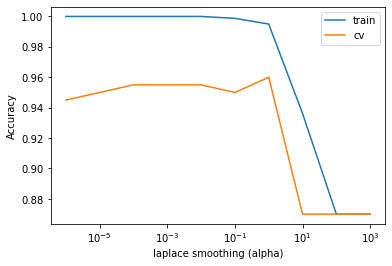

In [24]:
plt.semilogx(param_grid["alpha"],results_dict["mean_train_score"],label="train");
plt.semilogx(param_grid["alpha"],results_dict["mean_cv_score"],label="cv");
plt.legend();
plt.xlabel('laplace smoothing (alpha)');
plt.ylabel('Accuracy');

#### Questions: True or False 
- Laplace smoothing helps us deal with unknown words, the words that do not occur in the vocabulary of the training set. 

## 4. Naive Bayes with continuous features

- We can use Gaussian Naive Bayes if you have continuous features. 

In [60]:
df = pd.read_csv("data/canada_usa_cities.csv")
train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 123) # 80%-20% train test split on df
X_train, y_train = train_df.drop(columns=["country"]), train_df["country"] 
X_test, y_test = test_df.drop(columns=["country"]), test_df["country"]
train_df.head()

,longitude,latitude,country
160,-76.4813,44.2307,Canada
127,-81.2496,42.9837,Canada
169,-66.0580,45.2788,Canada
188,-73.2533,45.3057,Canada
187,-67.9245,47.1652,Canada


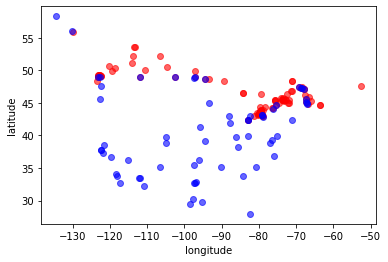

In [61]:
canada = train_df.query('country == "Canada"')
usa = train_df.query('country == "USA"')
plt.scatter(canada["longitude"], canada["latitude"], color="red", alpha=0.6)
plt.scatter(usa["longitude"], usa["latitude"], color="blue", alpha=0.6)
plt.ylabel("latitude")
plt.xlabel("longitude");

###  Gaussian Naive Bayes

- Our cities dataset has continuous-valued features.
- But so far, we've only seen how to use Naive Bayes for discrete features.
- We can either discretize our continuous features into discrete bins (with counts), or...
- Use _Gaussian_ naive Bayes (read more [here](https://machinelearningmastery.com/naive-bayes-for-machine-learning/) and [here](https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Gaussian_naive_Bayes))
- This sounds complicated but is actually quite simple:
    - Assume each feature is normally distributed 
    - Calculate the mean ($\mu_k$) and standard deviation ($\sigma_k$) for each feature for each class
    - Use the following equation to calculate the conditional probability of observing feature value $v$ in class $C_k$

<img src='./images/gaus_nb.png' width="400">


Source: [Wikipedia](https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Gaussian_naive_Bayes)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8421a30880>,
      dtype=object)

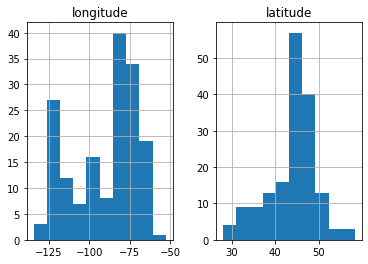

In [62]:
X_train.hist()

- Gaussian naive Bayes assumes normality
    - Are our features normal?
    - Not really but in practice we transform our data to try and make it more normal
    - Scikit-learn provides the `PowerTransformer()` for this process
    - From the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html#sklearn.preprocessing.PowerTransformer): "*...Power transforms are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like.*"    

In [63]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
X_train[['longitude', 'latitude']] = pt.fit_transform(X_train)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f84223bde80>,
      dtype=object)

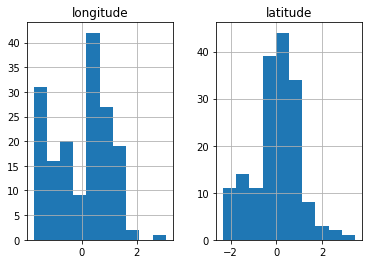

In [64]:
X_train.hist()

### Let's visualize probabilistic predictions

Text(0.5, 1.0, 'Naive Bayes decision boundary')

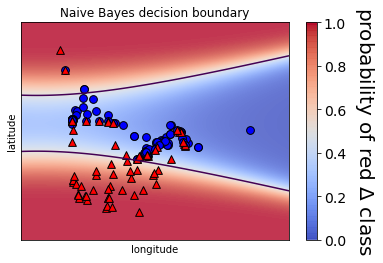

In [66]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)

plt.figure()
ax = plt.gca()
plot_classifier(X_train, y_train, model, ax=ax, proba=True);

plt.ylabel("latitude");
plt.xlabel("longitude");
plt.title("Naive Bayes decision boundary")

- Predictions in darker colours: the model is more confident
- Predictions in lighter colours: the model is less confident

## 5. Naive Bayes on multi-class problems 

Let's use `sklearn`'s inbuilt 20 newsgroups dataset. It comprises around 18,000 newsgroups posts on 20 topics. So it's a 20-class classification problem. 

In [28]:
from sklearn import datasets
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers','footers','quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers','footers','quotes'))
X_news_train, y_news_train = newsgroups_train.data, newsgroups_train.target
X_news_test, y_news_test = newsgroups_test.data, newsgroups_test.target

Here are the 20 topics (targets or classes) in the dataset. 

In [29]:
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

### Let's try `DummyClassifier`

In [30]:
pipe_multi = make_pipeline(CountVectorizer(), DummyClassifier(strategy="most_frequent"))
scores = cross_validate(pipe_multi, X_news_train, y_news_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.897788,0.195109,0.053027,0.053033
1,0.878481,0.222103,0.053027,0.053033
2,0.902842,0.201383,0.053027,0.053033
3,0.916285,0.204620,0.053027,0.053033
4,0.930153,0.187737,0.053050,0.053027


The scores are very low because we have 20 different classes!! 

### Let's try `MultinomialNB`

In [31]:
pipe_multi = make_pipeline(CountVectorizer(), MultinomialNB())
scores = cross_validate(pipe_multi, X_news_train, y_news_train, return_train_score=True)

In [32]:
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.971424,0.212912,0.583738,0.741465
1,0.943519,0.225378,0.570040,0.739587
2,0.952782,0.216721,0.583297,0.749309
3,0.974784,0.205032,0.571365,0.731963
4,0.963277,0.195200,0.588859,0.739063


The validation scores are low but much better than the `DummyClassifier`.  

Let's try to predict on an example. 

In [33]:
pipe_multi.fit(X_news_train, y_news_train); 

In [34]:
print(X_news_test[100])
prediction = pipe_multi.predict([X_news_test[100]])[0]
print('Prediction index: %d and prediction class: %s' %(prediction, newsgroups_train.target_names[prediction]))

Hello All!

    It is my understanding that all True-Type fonts in Windows are loaded in
prior to starting Windows - this makes getting into Windows quite slow if you
have hundreds of them as I do.  First off, am I correct in this thinking -
secondly, if that is the case - can you get Windows to ignore them on boot and
maybe make something like a PIF file to load them only when you enter the
applications that need fonts?  Any ideas?


Chris
Prediction index: 5 and prediction class: comp.windows.x


And here are prediction probabilities. 

In [35]:
pipe_multi.predict_proba([X_news_test[100]])

array([[7.26904475e-19, 1.48743104e-10, 4.16538604e-28, 2.96340768e-10,
        1.91391647e-14, 1.00000000e+00, 4.34194388e-28, 2.40916532e-18,
        9.74009600e-22, 1.72603033e-31, 5.61184330e-31, 8.76853929e-14,
        1.00705690e-16, 2.70331089e-13, 2.36762710e-21, 5.91222397e-16,
        3.61589511e-15, 1.49715839e-13, 2.92789387e-16, 1.20413840e-24]])

### Generative models
 
- Naive Bayes is a **generative model** because it's modeling the joint distribution over the features $X$ and labels $y$.
- In the next lecture, we'll look at a **discriminative model**, which models $P(y\mid X)$ rather than $P(X,y)$.
- Right now just get familiar with these terms. We'll talk more about them later in the program. 

### General comments on naive Bayes

- Surprising accuracy 
- A fast and robust way to learn the corresponding parameters
- Scales great; learning a naive Bayes classifier is just a matter of counting how many times each attribute co-occurs with each class
- Can be easily used for multi-class classification. 
- It's closely related to linear classifiers we'll see in the next lecture. 
    - When we take the logarithms, the products turn into summations. 
- Can provides a informative set of features from which to predict the class (next class)

### General comments on naive Bayes

- Assumes that spammers generate e-mails by picking words at random. It means that sentences have no syntax and content. Is that a fair assumption? 
    - oversimplification 
    - sometimes the best theories are the most oversimplified, provided their predictions are accurate, because they explain the most with the least. 

- Although naive Bayes is known as a decent classifier, it is known to be a **bad estimator**, so the probability outputs from `predict_proba` are not to be taken too seriously.


### TRUE/False questions for class discussion

> 1. Laplace smoothing helps us deal with unknown words, the words that do not occur in the vocabulary of the training set. 

Varada's answer: False

> 2. Naive Bayes should only be used if the "naive" conditional independence assumption holds for your problem.

Varada's answer: leaning towards False

> 3. Naive Bayes should only be used when the features (i.e. `X`-values) are binary.

Varada's answer: False.
